In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import mode, skew, kurtosis, entropy
from sklearn.ensemble import ExtraTreesRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

transact_cols = [f for f in train.columns if f not in ["ID", "target"]]
y = np.log1p(train["target"]).values

In [3]:
cols = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
       '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
       'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
       '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212',  '66ace2992',
       'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
       '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a',
       '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2',  '0572565c2',
       '190db8488',  'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98'] 

In [4]:
from multiprocessing import Pool

CPU_CORES = 1

def _get_leak(df, cols, lag=0):
    """ To get leak value, we do following:
       1. Get string of all values after removing first two time steps
       2. For all rows we shift the row by two steps and again make a string
       3. Just find rows where string from 2 matches string from 1
       4. Get 1st time step of row in 3 (Currently, there is additional condition to only fetch value if we got exactly one match in step 3)"""
    series_str = df[cols[lag+2:]].apply(lambda x: "_".join(x.round(2).astype(str)), axis=1)
    series_shifted_str = df[cols].shift(lag+2, axis=1)[cols[lag+2:]].apply(lambda x: "_".join(x.round(2).astype(str)), axis=1)
    target_rows = series_shifted_str.progress_apply(lambda x: np.where(x == series_str)[0])
    target_vals = target_rows.apply(lambda x: df.loc[x[0], cols[lag]] if len(x)==1 else 0)
    return target_vals

def get_all_leak(df, cols=None, nlags=15):
    """
    We just recursively fetch target value for different lags
    """
    df =  df.copy()
    #with Pool(processes=CPU_CORES) as p:
    #    res = [p.apply_async(_get_leak, args=(df, cols, i)) for i in range(nlags)]
    #    res = [r.get() for r in res]
    
    for i in range(nlags):
        print("Processing lag {}".format(i))
        df["leaked_target_"+str(i)] = _get_leak(df, cols, i)
    return df

In [5]:
test["target"] = train["target"].mean()

all_df = pd.concat([train[["ID", "target"] + cols], test[["ID", "target"]+ cols]]).reset_index(drop=True)
all_df.head()

,ID,target,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,...,6619d81fc,1db387535,fc99f9426,91f701ba2,0572565c2,190db8488,adb64ff71,c47340d97,c5a231d81,0ff32eb98
0,000d6aaf2,38000000.0,1866666.66,12066666.66,700000.0,600000.0,900000.0,4100000.0,0.0,0.0,...,400000.0,0.0,0.0,5000000.0,400000.0,0.0,0.0,0.0,0.0,0.0
1,000fbd867,600000.0,0.00,2850000.00,2225000.0,1800000.0,800000.0,0.0,0.0,3300000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0027d6b71,10000000.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,6000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0028cbf45,2000000.0,2000000.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002a68644,14400000.0,0.00,0.00,0.0,0.0,37662000.0,0.0,4000000.0,6700000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000000.0,0.0,0.0


In [6]:
NLAGS = 2 #Increasing this might help push score a bit
all_df = get_all_leak(all_df, cols=cols, nlags=NLAGS)

Processing lag 0


100%|██████████| 53801/53801 [04:30<00:00, 198.57it/s]


Processing lag 1


100%|██████████| 53801/53801 [04:26<00:00, 201.96it/s]


In [12]:
all_df['leaked_target_1']

0        38000000.00
1               0.00
2               0.00
3               0.00
4               0.00
5               0.00
6               0.00
7               0.00
8          979000.00
9               0.00
10              0.00
11              0.00
12              0.00
13              0.00
14              0.00
15              0.00
16         200000.00
17              0.00
18              0.00
19              0.00
20              0.00
21        3266666.66
22        6140000.00
23       14886000.00
24              0.00
25              0.00
26              0.00
27              0.00
28              0.00
29              0.00
            ...     
53771           0.00
53772           0.00
53773           0.00
53774           0.00
53775           0.00
53776           0.00
53777           0.00
53778           0.00
53779           0.00
53780           0.00
53781           0.00
53782           0.00
53783           0.00
53784    16000000.00
53785    20000000.00
53786           0.00
53787        

In [14]:
leaky_cols = ["leaked_target_"+str(i) for i in range(NLAGS)]
train_d = train.join(all_df.set_index("ID")[leaky_cols], on="ID", how="left")

In [18]:
train_d

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466,leaked_target_0,leaked_target_1
0,000d6aaf2,38000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,38000000.00,38000000.00
1,000fbd867,600000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,600000.00,0.00
2,0027d6b71,10000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0.00,0.00
3,0028cbf45,2000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0.00,0.00
4,002a68644,14400000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0.00,0.00
5,002dbeb22,2800000.00,0.0,0,0.0,0,0,0,0,0,...,20000000.0,0,0,0,0,0,0,11000,0.00,0.00
6,003925ac6,164000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,40000,0,0,0,0.00,0.00
7,003eb0261,600000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,600000.00,0.00
8,004b92275,979000.00,0.0,0,0.0,0,0,0,0,0,...,4000000.0,0,0,0,0,0,0,0,979000.00,979000.00
9,0067b4fef,460000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,400000,0.00,0.00


In [23]:
train_d.iloc[1:3, 1:3]

,target,48df886f9
1,600000.0,0.0
2,10000000.0,0.0


In [25]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53801 entries, 0 to 53800
Data columns (total 44 columns):
ID                 53801 non-null object
target             53801 non-null float64
f190486d6          53801 non-null float64
58e2e02e6          53801 non-null float64
eeb9cd3aa          53801 non-null float64
9fd594eec          53801 non-null float64
6eef030c1          53801 non-null float64
15ace8c9f          53801 non-null float64
fb0f5dbfe          53801 non-null float64
58e056e12          53801 non-null float64
20aa07010          53801 non-null float64
024c577b9          53801 non-null float64
d6bb78916          53801 non-null float64
b43a7cfd5          53801 non-null float64
58232a6fb          53801 non-null float64
1702b5bf0          53801 non-null float64
324921c7b          53801 non-null float64
62e59a501          53801 non-null float64
2ec5b290f          53801 non-null float64
241f0f867          53801 non-null float64
fb49e4212          53801 non-null float64
66ace2992 

In [43]:
import collections
len(collections.Counter(train['target']).keys())
a = list(collections.Counter(train['target']).keys())

In [45]:
a.sort()

In [46]:
a

[30000.0,
 31333.34,
 32000.0,
 32500.0,
 33000.0,
 33333.34,
 34000.0,
 34307.7,
 35000.0,
 36000.0,
 36666.66,
 37000.0,
 37333.34,
 38000.0,
 40000.0,
 42000.0,
 42857.14,
 43333.34,
 44000.0,
 46000.0,
 47000.0,
 48000.0,
 48333.34,
 48666.66,
 50000.0,
 51000.0,
 52000.0,
 53000.0,
 54000.0,
 55000.0,
 56000.0,
 57000.0,
 57333.34,
 58000.0,
 59333.34,
 60000.0,
 60666.66,
 62000.0,
 63333.34,
 64000.0,
 65000.0,
 66000.0,
 67000.0,
 67500.0,
 68000.0,
 69000.0,
 70000.0,
 72000.0,
 72666.66,
 74000.0,
 74888.88,
 75000.0,
 75333.34,
 76000.0,
 78000.0,
 80000.0,
 80666.66,
 82000.0,
 82666.66,
 83000.0,
 83500.0,
 85000.0,
 85500.0,
 86666.66,
 88000.0,
 89000.0,
 90000.0,
 90500.0,
 91142.86,
 92000.0,
 92500.0,
 94000.0,
 96000.0,
 97000.0,
 98000.0,
 98666.66,
 100000.0,
 100500.0,
 101000.0,
 102000.0,
 103000.0,
 104000.0,
 105000.0,
 106000.0,
 108000.0,
 110000.0,
 110800.0,
 112000.0,
 113000.0,
 113333.34,
 114000.0,
 115000.0,
 115636.36,
 118000.0,
 118666.66,
 120000.

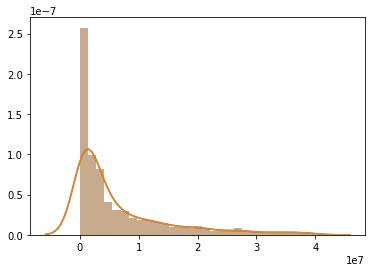

In [48]:
sns.distplot(a)
plt.show()

In [49]:
np.mean(a)

6379671.6022080677

In [50]:
b = np.log1p(a)

In [53]:
np.mean(b)

14.632974068540145

In [56]:
b = list(b)

In [57]:
b.sort()

In [58]:
b

[10.308985993422082,
 10.352469899727524,
 10.373522431293592,
 10.389026137075234,
 10.404293143019792,
 10.414343375846109,
 10.434145214930487,
 10.443154245306619,
 10.463131911491967,
 10.491301994830229,
 10.509650446648582,
 10.518700218288165,
 10.527668825531306,
 10.545367754151743,
 10.596659732783579,
 10.645448706505872,
 10.665650870979027,
 10.67670067126901,
 10.691967639914864,
 10.736418414365376,
 10.757924157061597,
 10.778977123006351,
 10.785897560103917,
 10.792770022772967,
 10.819798284210286,
 10.839600519357369,
 10.859018228147887,
 10.878066060280791,
 10.896757843893464,
 10.915106645867503,
 10.933124826700707,
 10.950824090522445,
 10.956655025112873,
 10.968215530759236,
 10.990943506754322,
 11.002116507732017,
 11.01316605088315,
 11.034905792929415,
 11.056182957085035,
 11.066653987219739,
 11.082157933374816,
 11.097425172408931,
 11.112462823634855,
 11.119897691565697,
 11.127277689932466,
 11.141876276228,
 11.156264806643742,
 11.18443528679063

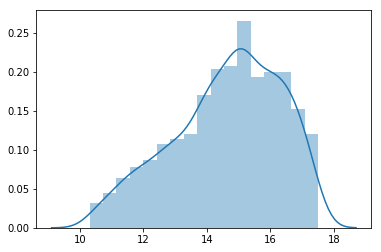

In [60]:
sns.distplot(b)
plt.show()

In [62]:
np.min(b)

10.308985993422082

In [65]:
c = collections.Counter(train['target'])

In [81]:
sorted_d = [(k,v) for k,v in c.items()]

In [86]:
sorted_d.sort(key=lambda x: x[1], reverse=True)

In [87]:
sorted_d

[(2000000.0, 207),
 (10000000.0, 199),
 (20000000.0, 156),
 (4000000.0, 148),
 (1000000.0, 129),
 (400000.0, 115),
 (200000.0, 113),
 (5000000.0, 101),
 (6000000.0, 88),
 (600000.0, 84),
 (8000000.0, 65),
 (3000000.0, 61),
 (800000.0, 59),
 (100000.0, 44),
 (40000.0, 40),
 (40000000.0, 40),
 (30000000.0, 39),
 (500000.0, 39),
 (1200000.0, 39),
 (300000.0, 37),
 (1600000.0, 33),
 (7000000.0, 31),
 (1400000.0, 31),
 (1500000.0, 30),
 (1800000.0, 28),
 (700000.0, 28),
 (30000.0, 26),
 (50000.0, 25),
 (60000.0, 24),
 (14000000.0, 21),
 (15000000.0, 21),
 (12000000.0, 20),
 (2500000.0, 20),
 (16000000.0, 19),
 (2400000.0, 18),
 (9000000.0, 17),
 (11000000.0, 16),
 (2200000.0, 15),
 (18000000.0, 14),
 (2800000.0, 13),
 (24000000.0, 13),
 (120000.0, 13),
 (25000000.0, 12),
 (150000.0, 12),
 (900000.0, 12),
 (1100000.0, 11),
 (3600000.0, 11),
 (160000.0, 11),
 (3500000.0, 11),
 (450000.0, 11),
 (36000000.0, 11),
 (3200000.0, 11),
 (80000.0, 11),
 (4500000.0, 10),
 (2600000.0, 10),
 (1900000.0,

In [113]:
top_n = 500
sum([v[1] for v in sorted_d[:top_n]]) / 4459

0.7952455707557748

In [105]:
t = [v[0] for v in sorted_d[:top_n]]
np.mean(np.log1p(t))

14.122760429769617

In [111]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [118]:
sum([v[1] for v in sorted_d if v[1] > 3]) / 4459

0.6577708006279435

In [129]:
col = train[cols[10]]
c_0 = collections.Counter(col)

In [130]:
c_0

Counter({0.0: 3022,
         2000.0: 12,
         4000.0: 4,
         6000.0: 4,
         8000.0: 4,
         10000.0: 8,
         10666.66: 1,
         12000.0: 2,
         13000.0: 1,
         14000.0: 2,
         15000.0: 1,
         16000.0: 2,
         18000.0: 1,
         18666.66: 1,
         20000.0: 9,
         21333.34: 1,
         22000.0: 1,
         23333.34: 1,
         24000.0: 4,
         26000.0: 1,
         28000.0: 1,
         29000.0: 5,
         30000.0: 7,
         30666.66: 1,
         32000.0: 1,
         32500.0: 1,
         34000.0: 1,
         35000.0: 2,
         36000.0: 1,
         40000.0: 11,
         42000.0: 2,
         46000.0: 2,
         48000.0: 2,
         50000.0: 5,
         52000.0: 1,
         55000.0: 1,
         57000.0: 1,
         58000.0: 7,
         60000.0: 3,
         60666.66: 1,
         62000.0: 1,
         64800.0: 3,
         66000.0: 1,
         67000.0: 1,
         68000.0: 2,
         69000.0: 1,
         70000.0: 2,
         7

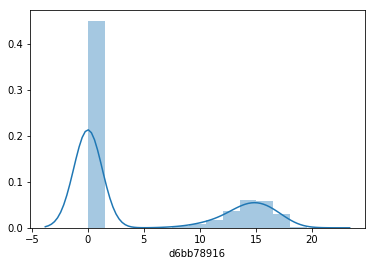

In [132]:
sns.distplot(np.log1p(col))
plt.show()

In [139]:
td = train.drop(['ID', 'target'], axis=1)

In [144]:
im = np.log1p(td.values)

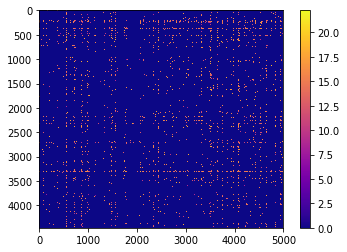

In [154]:
plt.imshow(im, cmap='plasma')
plt.colorbar()
plt.savefig('train.png')
plt.show()

In [161]:
train[2:3].values

array([['0027d6b71', 10000000.0, 0.0, ..., 0, 0, 0]], dtype=object)